**Описание столбцов для train и test:** 

- id -  уникальный идентификатор столбца; 
- ticket_id - уникальный идентификатор билета, считается, что у одного билета один владелец 
- ticket_type_nm - тип билета 
- entrance_id - уникальный id входа в станцию 
- entrance_nm -  название 
- station_id - уникальное id станции захода 
- station_nm - наименование станции захода 
- line_id - уникальный id ветки на, которой находится станция 
- line_nm - наименование ветки, на которой находится станция 
- pass_dttm - дата валидации 
- **time_to_under (столбец для предсказания)** - сколько времени прошло между первой и второй валидацией 
- **label (столбец для предсказания)** - id второй станции, на которой произошла валидация

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, r2_score
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_test = pd.read_csv('C:/data/hackathon/amur_champ/test_dataset_test.csv')
df_test

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm
0,1091022,425A13E16226CA01032043111488E0F5,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03
1,1091023,F94EDC107A4E054786882F9453C1B93F,Пропуск FacePay,184,Молодёжная (Западный),3010,Молодёжная,3,Арбатско-Покровская,2022-09-12 05:00:45
2,1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,СК студента 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:52
3,1091025,7B98691636EC418ABF6FEDDE4D7C68FC,КОШЕЛЕК,107,Сокол ( Южн./Вост. ),2018,Сокол,2,Замоскворецкая,2022-09-12 05:00:58
4,1091026,679C55C28CB36FB546FD104502C0B3DB,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:39
...,...,...,...,...,...,...,...,...,...,...
561885,1652907,B6FADEB8705FAF8E9DFD9016A613D997,Пропуск FacePay,279,Калужская (Южный),6007,Калужская,6,Калужско-Рижская,2022-09-19 01:33:11
561886,1652908,77F2868FC2648ACCBD58F1F8AB66C321,Пропуск FacePay,2463,Кунцевская БКЛ (Первый),11020,Кунцевская,11,Большая кольцевая,2022-09-19 02:03:59
561887,1652909,29A4ACF592877817B8D00D969DFDB681,Пропуск FacePay,64,Проспект Вернадского ( Южный ),1012,Проспект Вернадского,1,Сокольническая,2022-09-19 02:51:34
561888,1652910,DE9EBEFD0DF4A351013AA574B075F535,Пропуск FacePay,285,Коньково (Южный),6009,Коньково,6,Калужско-Рижская,2022-09-19 02:58:10


In [3]:
subway = pd.read_csv('C:/data/hackathon/amur_champ/subway/subway.csv')
subway

,Unnamed: 0,global_route_id,route_id,route_num,start_station_id,start_station_nm,start_line_id,start_line_nm,all_stations_id,all_stations_nm,station_cnt,transit_cnt,sector_cnt,alternative_route_cnt,route_dur,optimal_route_delta
0,0,7018_10001,10001_7018,9,10001,Борисово,10,Люблинско-Дмитровская,"[10001,10013,10002,10011,10005,10016,10009,100...","[""Борисово"",""Марьино"",""Братиславская"",""Люблино...",26,3,4,30,64.59,8.58
1,1,7018_10001,10001_7018,1,10001,Борисово,10,Люблинско-Дмитровская,"[10001,10013,10002,10011,10005,10016,10009,100...","[""Борисово"",""Марьино"",""Братиславская"",""Люблино...",23,1,2,30,56.01,0.00
2,2,7018_10001,10001_7018,2,10001,Борисово,10,Люблинско-Дмитровская,"[10001,10013,10002,10011,10005,10016,10009,100...","[""Борисово"",""Марьино"",""Братиславская"",""Люблино...",25,2,3,30,61.01,5.00
3,3,7018_10001,10001_7018,3,10001,Борисово,10,Люблинско-Дмитровская,"[10001,10013,10002,10011,10005,10016,10009,100...","[""Борисово"",""Марьино"",""Братиславская"",""Люблино...",26,2,3,30,61.81,5.80
4,4,7018_10001,10001_7018,4,10001,Борисово,10,Люблинско-Дмитровская,"[10001,10013,10002,10011,10005,10016,10009,100...","[""Борисово"",""Марьино"",""Братиславская"",""Люблино...",25,2,3,30,62.01,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991566,2991566,8001_9022,9022_8001,29,9022,Цветной бульвар,9,Серпуховско-Тимирязевская,"[9022,10020,10019,10022,5006,5012,7019,8002,80...","[""Цветной бульвар"",""Трубная"",""Сретенский бульв...",10,4,3,33,27.71,11.30
2991567,2991567,8001_9022,9022_8001,30,9022,Цветной бульвар,9,Серпуховско-Тимирязевская,"[9022,9024,2019,2020,3015,3008,10022,10017,800...","[""Цветной бульвар"",""Чеховская"",""Тверская"",""Теа...",10,4,5,33,27.71,11.30
2991568,2991568,8001_9022,9022_8001,31,9022,Цветной бульвар,9,Серпуховско-Тимирязевская,"[9022,10020,10019,1021,6022,6008,7006,7019,800...","[""Цветной бульвар"",""Трубная"",""Сретенский бульв...",11,5,4,33,27.71,11.30
2991569,2991569,8001_9022,9022_8001,32,9022,Цветной бульвар,9,Серпуховско-Тимирязевская,"[9022,9024,7015,7008,7006,6008,6022,10019,1002...","[""Цветной бульвар"",""Чеховская"",""Пушкинская"",""К...",12,4,5,33,27.81,11.40


In [4]:
df_train = pd.read_csv('C:/data/hackathon/amur_champ/train_dataset_train.csv')
df_train

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
1091016,1091017,6A738232F8E43DFCD4027FDC0EA6CC03,Пропуск FacePay,2283,Нижегородская (второй),15005,Нижегородская,15,Некрасовская,2022-09-19 02:54:50,124.750000,15005
1091017,1091018,141174B366F14A8703903813A49374DB,Пропуск FacePay,278,Калужская (Северный),6007,Калужская,6,Калужско-Рижская,2022-09-19 03:06:02,56.066667,6007
1091018,1091019,E38493B30A7C55170806F187AF5EEA15,Пропуск FacePay,118,Каширская (Северный ),2010,Каширская,2,Замоскворецкая,2022-09-19 03:17:00,91.283333,2010
1091019,1091020,3DF2B6366631ECA06274DD2CB5B0DF24,Пропуск FacePay,2452,Воронцовская (Первый),11014,Воронцовская,11,Большая кольцевая,2022-09-19 03:23:30,47.900000,11014


## Предобработка и исследовательский анализ данных

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091021 entries, 0 to 1091020
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1091021 non-null  int64  
 1   ticket_id       1091021 non-null  object 
 2   ticket_type_nm  1091021 non-null  object 
 3   entrance_id     1091021 non-null  int64  
 4   entrance_nm     1091021 non-null  object 
 5   station_id      1091021 non-null  int64  
 6   station_nm      1091021 non-null  object 
 7   line_id         1091021 non-null  int64  
 8   line_nm         1091021 non-null  object 
 9   pass_dttm       1091021 non-null  object 
 10  time_to_under   1091021 non-null  float64
 11  label           1091021 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 99.9+ MB


In [6]:
df_train.describe()

,id,entrance_id,station_id,line_id,time_to_under,label
count,1.091021e+06,1.091021e+06,1.091021e+06,1.091021e+06,1.091021e+06,1.091021e+06
mean,5.455110e+05,8.581884e+02,8.601452e+03,8.590013e+00,5.104668e+02,7.723527e+03
std,3.149508e+05,9.003577e+02,1.247133e+04,1.247157e+01,2.328452e+02,1.167015e+04
min,1.000000e+00,2.000000e+01,1.002000e+03,1.000000e+00,3.001667e+01,1.002000e+03
25%,2.727560e+05,2.150000e+02,3.018000e+03,3.000000e+00,3.229500e+02,3.006000e+03
50%,5.455110e+05,3.370000e+02,7.009000e+03,7.000000e+00,5.686833e+02,6.013000e+03
75%,8.182660e+05,2.087000e+03,9.022000e+03,9.000000e+00,6.838833e+02,9.012000e+03
max,1.091021e+06,2.466000e+03,8.101600e+04,8.100000e+01,1.437417e+03,8.101600e+04


In [7]:
len(df_train.id.unique())

1091021

In [8]:
df_train = df_train.set_index('id')
df_train

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
id,,,,,,,,,,,
1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017
...,...,...,...,...,...,...,...,...,...,...,...
1091017,6A738232F8E43DFCD4027FDC0EA6CC03,Пропуск FacePay,2283,Нижегородская (второй),15005,Нижегородская,15,Некрасовская,2022-09-19 02:54:50,124.750000,15005
1091018,141174B366F14A8703903813A49374DB,Пропуск FacePay,278,Калужская (Северный),6007,Калужская,6,Калужско-Рижская,2022-09-19 03:06:02,56.066667,6007
1091019,E38493B30A7C55170806F187AF5EEA15,Пропуск FacePay,118,Каширская (Северный ),2010,Каширская,2,Замоскворецкая,2022-09-19 03:17:00,91.283333,2010


In [9]:
len(df_train.ticket_id.unique())

335533

In [10]:
df_train.groupby('ticket_id')['label'].count()

ticket_id
0000127DEF21FE03B73E7446B1CD950D    4
0000384F57624A46FC50B1791DD35375    1
0000680906DD9A73E4643DE01195B9FF    7
000073DF4F8CF7B060FC4AB79C2A7502    2
00007E506A1D6ED43C69EB66DF9AAC8C    2
                                   ..
FFFF0CEE67A7165E9E152B85695EA95B    7
FFFF456A58208537D5964CA3D67C7BA0    1
FFFFAE68D28C5F9BFB89107D1803454A    4
FFFFED6C9012845A5075CAC6501C3940    6
FFFFF45B8BE42C41845D1FBC7775A8E6    7
Name: label, Length: 335533, dtype: int64

In [11]:
df_train.query('ticket_id=="0000127DEF21FE03B73E7446B1CD950D"')

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
id,,,,,,,,,,,
101790,0000127DEF21FE03B73E7446B1CD950D,30 дней ЕДИНЫЙ ТК,300,Рязанский проспект (Восточный),7016,Рязанский проспект,7,Таганско-Краснопресненская,2022-09-12 09:05:25,622.716667,9001
276348,0000127DEF21FE03B73E7446B1CD950D,30 дней ЕДИНЫЙ ТК,300,Рязанский проспект (Восточный),7016,Рязанский проспект,7,Таганско-Краснопресненская,2022-09-13 09:13:00,603.966667,9001
889114,0000127DEF21FE03B73E7446B1CD950D,30 дней ЕДИНЫЙ ТК,300,Рязанский проспект (Восточный),7016,Рязанский проспект,7,Таганско-Краснопресненская,2022-09-17 08:56:28,737.633333,9001
1013850,0000127DEF21FE03B73E7446B1CD950D,30 дней ЕДИНЫЙ ТК,300,Рязанский проспект (Восточный),7016,Рязанский проспект,7,Таганско-Краснопресненская,2022-09-18 09:12:17,651.383333,9001


In [12]:
df_train.query('ticket_id=="FFFFAE68D28C5F9BFB89107D1803454A"')

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
id,,,,,,,,,,,
222339,FFFFAE68D28C5F9BFB89107D1803454A,30 дней ЕДИНЫЙ ТК,147,Измайловская ( Восточный ),3004,Измайловская,3,Арбатско-Покровская,2022-09-13 07:50:00,477.883333,3002
494065,FFFFAE68D28C5F9BFB89107D1803454A,30 дней ЕДИНЫЙ ТК,147,Измайловская ( Восточный ),3004,Измайловская,3,Арбатско-Покровская,2022-09-14 15:11:58,379.066667,3002
644990,FFFFAE68D28C5F9BFB89107D1803454A,30 дней ЕДИНЫЙ ТК,147,Измайловская ( Восточный ),3004,Измайловская,3,Арбатско-Покровская,2022-09-15 11:44:35,374.683333,3002
728187,FFFFAE68D28C5F9BFB89107D1803454A,30 дней ЕДИНЫЙ ТК,147,Измайловская ( Восточный ),3004,Измайловская,3,Арбатско-Покровская,2022-09-16 07:55:44,192.416667,3002


Можно заметить, что один и тот же маршрут у одного пассажира, регулярно пользующегося проездным билетом, может занимать разное количество времени до повторной валидации.

In [13]:
df_test['ticket_id'].isin(df_train['ticket_id']).value_counts()

False    561890
Name: ticket_id, dtype: int64

In [14]:
# столбец с количеством дней, в которые пассажир пользовался билетом
df_train['days_use_count'] = df_train['ticket_id'].map(df_train['ticket_id'].value_counts())
df_train.head()

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,days_use_count
id,,,,,,,,,,,,
1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,1
2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,5
3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,5
4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022,6
5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017,4


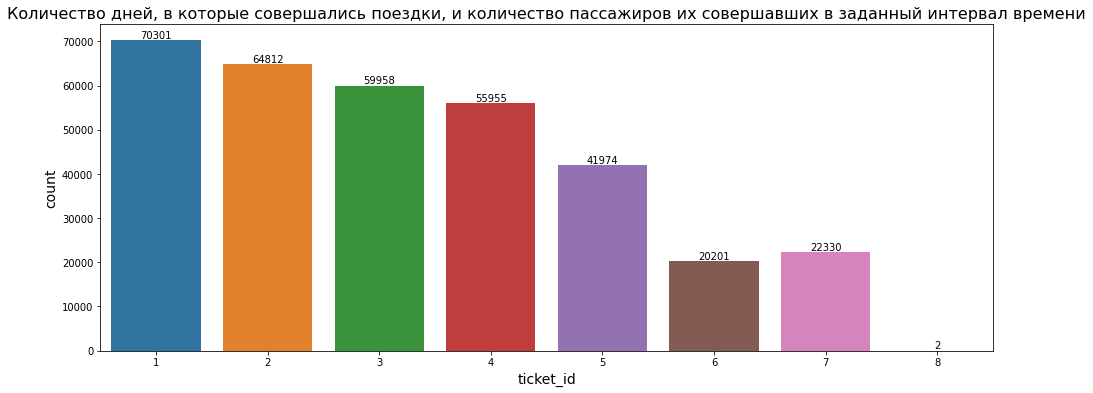

In [15]:
plt.figure(figsize=(16,6))
plt.title('Количество дней, в которые совершались поездки, и количество пассажиров их совершавших в заданный интервал времени', fontsize=16)
plt.xlabel('Количество дней', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax = sns.countplot(df_train.ticket_id.value_counts().sort_values(ascending=False))
for container in ax.containers:
    ax.bar_label(container);

In [16]:
df_train.ticket_type_nm.value_counts().sort_index()

1 сутки ЕДИНЫЙ ТК                                            123
1 сутки Пригород ТК                                            7
3 суток Единый ТК                                            504
30 дней                                                   117064
30 дней  Пригород                                           3098
30 дней ЕДИНЫЙ ТК                                         177041
30 дней Пригород ТК                                        45381
30 дней СК аспиранта                                        1045
30 дней СК ассистента-стажера                                 49
30 дней СК ординатора                                       1264
30 дней СК студента                                        48658
30 дней СК учащегося                                       24307
365 дней                                                     768
365 дней  Пригород                                            30
365 дней ЕДИНЫЙ ТК                                         20859
365 дней Пригород ТК     

Некоторые однотипные билеты записаны по разному. Приведем их к единому виду написания и сгруппируем по назначению.

In [17]:
df_train['ticket_type_nm'] = df_train['ticket_type_nm'].replace({'СК студента 30 дней':'СК студента',
                                                                'СК студента 90 дней':'СК студента',
                                                                'СК учащегося 30 дней':'СК учащегося',
                                                                'СК учащегося 90 дней':'СК учащегося',
                                                                'СК ординатора 30 дней':'СК ординатора',
                                                                'СК ординатора 90 дней':'СК ординатора',
                                                                'СК аспиранта 30 дней':'СК аспиранта',
                                                                'СК аспиранта 90 дней':'СК аспиранта',
                                                                'СК ассистента-стажера 30 дней':'СК ассистента-стажера',
                                                                'СК ассистента-стажера 90 дней':'СК ассистента-стажера',
                                                                
                                                                '30 дней СК студента':'СК студента',
                                                                '90 дней СК студента':'СК студента',
                                                                '30 дней СК учащегося':'СК учащегося',
                                                                '90 дней СК учащегося':'СК учащегося',
                                                                '30 дней СК ординатора':'СК ординатора',
                                                                '90 дней СК ординатора':'СК ординатора',
                                                                '30 дней СК аспиранта':'СК аспиранта',
                                                                '90 дней СК аспиранта':'СК аспиранта',
                                                                '30 дней СК ассистента-стажера':'СК ассистента-стажера',
                                                                
                                                                '30 дней  Пригород':'30 дней Пригород ТК',
                                                                '90 дней  Пригород':'90 дней Пригород ТК',
                                                                '365 дней  Пригород':'365 дней Пригород ТК',
                                                                'Билет 3 суток ЕДИНЫЙ':'3 суток ЕДИНЫЙ ТК',
                                                                '3 суток Единый ТК':'3 суток ЕДИНЫЙ ТК',
                                                                'Билет 1 сутки ЕДИНЫЙ':'1 сутки ЕДИНЫЙ ТК',
                                                                 
                                                                '30 дней':'30 дней ЕДИНЫЙ ТК',
                                                                '90 дней':'90 дней ЕДИНЫЙ ТК',
                                                                '365 дней':'365 дней ЕДИНЫЙ ТК',
                                                                
                                                                'Социальная карта жителя Моск. области':'СК жителя МО',
                                                                'Социальная карта жителя Моск. области с сопровождающим':'СК жителя МО с сопровождающим',
                                                                'Социальная карта москвича':'СК москвича',
                                                                'Социальная карта москвича с сопровождающим':'СК москвича с сопровождающим',
                                                                'ВЕСБ МО (7 мин)':'СК жителя МО',
                                                                'ВЕСБ МО (тип 5)':'СК жителя МО',
                                                                'ВЕСБ МО (тип 6)':'СК жителя МО',
                                                                'ВЕСБ МО с сопровождающим':'СК жителя МО с сопровождающим',
                                                                'ВЕСБ МОСКВА':'СК москвича',
                                                                'ВЕСБ МОСКВА (7мин)':'СК москвича',
                                                                'ВЛБ МОСКВА':'СК москвича',
                                                                'Временный билет ММ':'СК москвича',
                                                                'Безналичная транспортная карта':'КОШЕЛЕК'
                                                                })

df_train.ticket_type_nm.value_counts().sort_index()

1 сутки ЕДИНЫЙ ТК                                    125
1 сутки Пригород ТК                                    7
3 суток ЕДИНЫЙ ТК                                    617
30 дней ЕДИНЫЙ ТК                                 294105
30 дней Пригород ТК                                48479
365 дней ЕДИНЫЙ ТК                                 21627
365 дней Пригород ТК                                1203
60 поездок ЕДИНЫЙ ТК                               46542
90 дней ЕДИНЫЙ ТК                                  70888
90 дней Пригород ТК                                 2446
ББК                                                29674
БСК дружинника г.Москвы                             2829
КОШЕЛЕК                                           262559
Пропуск  сотрудника МЦК                               44
Пропуск FacePay                                     9234
Пропуск руководителя метрополитена                    24
Пропуск сотрудника  метрополитена                    113
Пропуск сотрудника УВД по охран

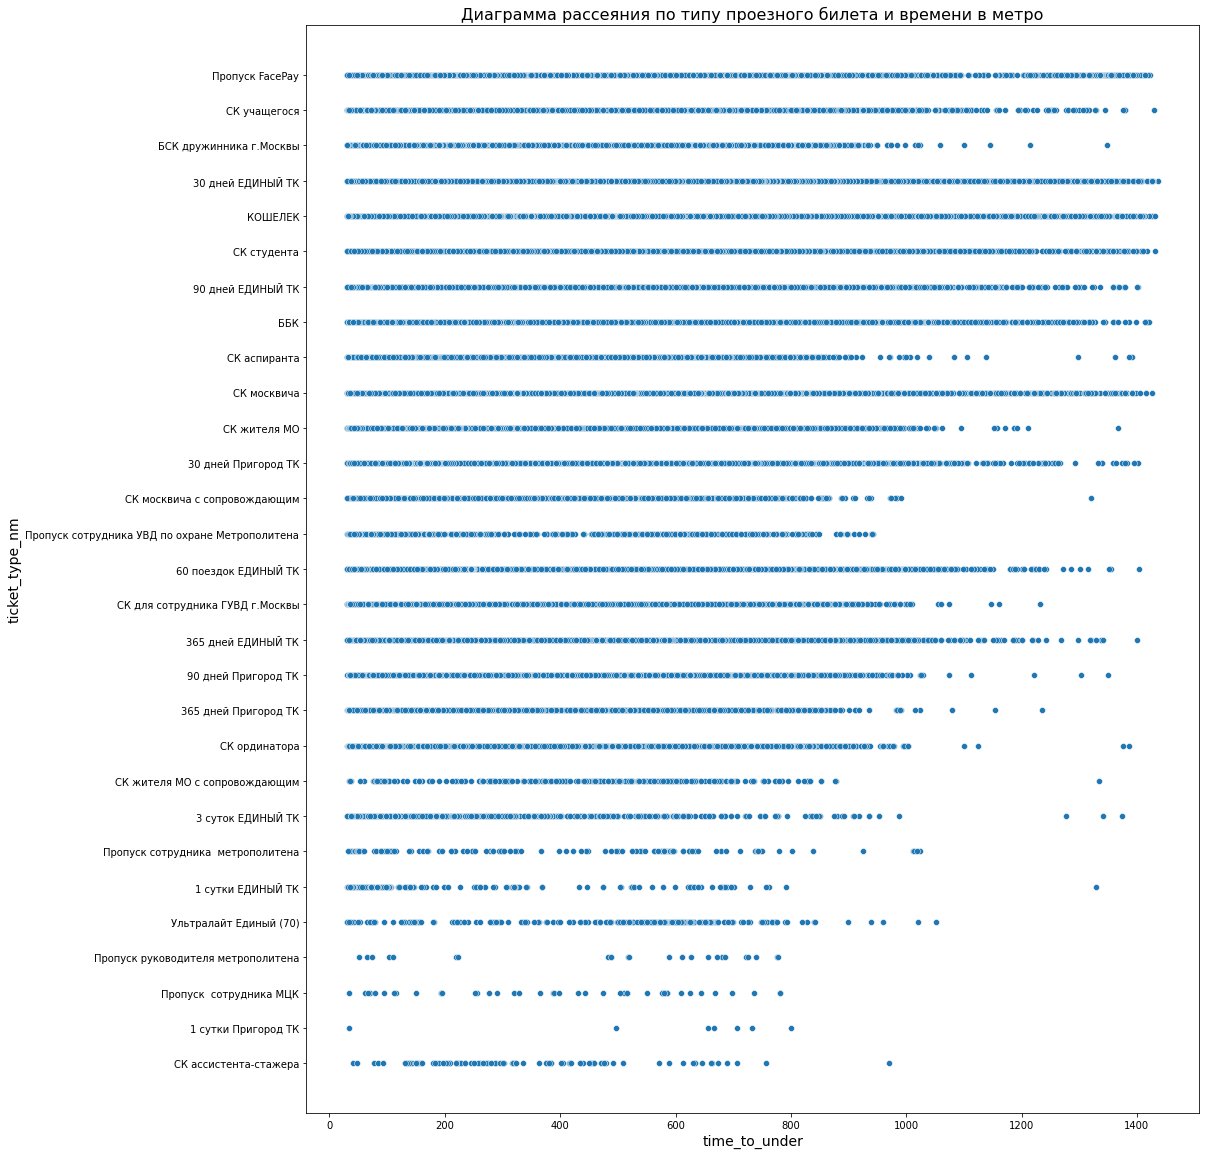

In [18]:
plt.figure(figsize=(16,20))
plt.title('Диаграмма рассеяния по типу проезного билета и времени в метро', fontsize=16)
plt.xlabel('time_to_under', fontsize=14)
plt.ylabel('ticket_type_nm', fontsize=14)
sns.scatterplot(x="time_to_under", y='ticket_type_nm', data=df_train);

In [19]:
# sns.jointplot(x="ticket_type_nm", y='time_to_under', data=df_train, kind='reg', height=16);

Отсутствует четкая зависимость между категорией проездного билета и временем захода в метро. Однако, видно, что для некоторых категорий билетов характерны меньшие временные интервалы до повторной валидации.

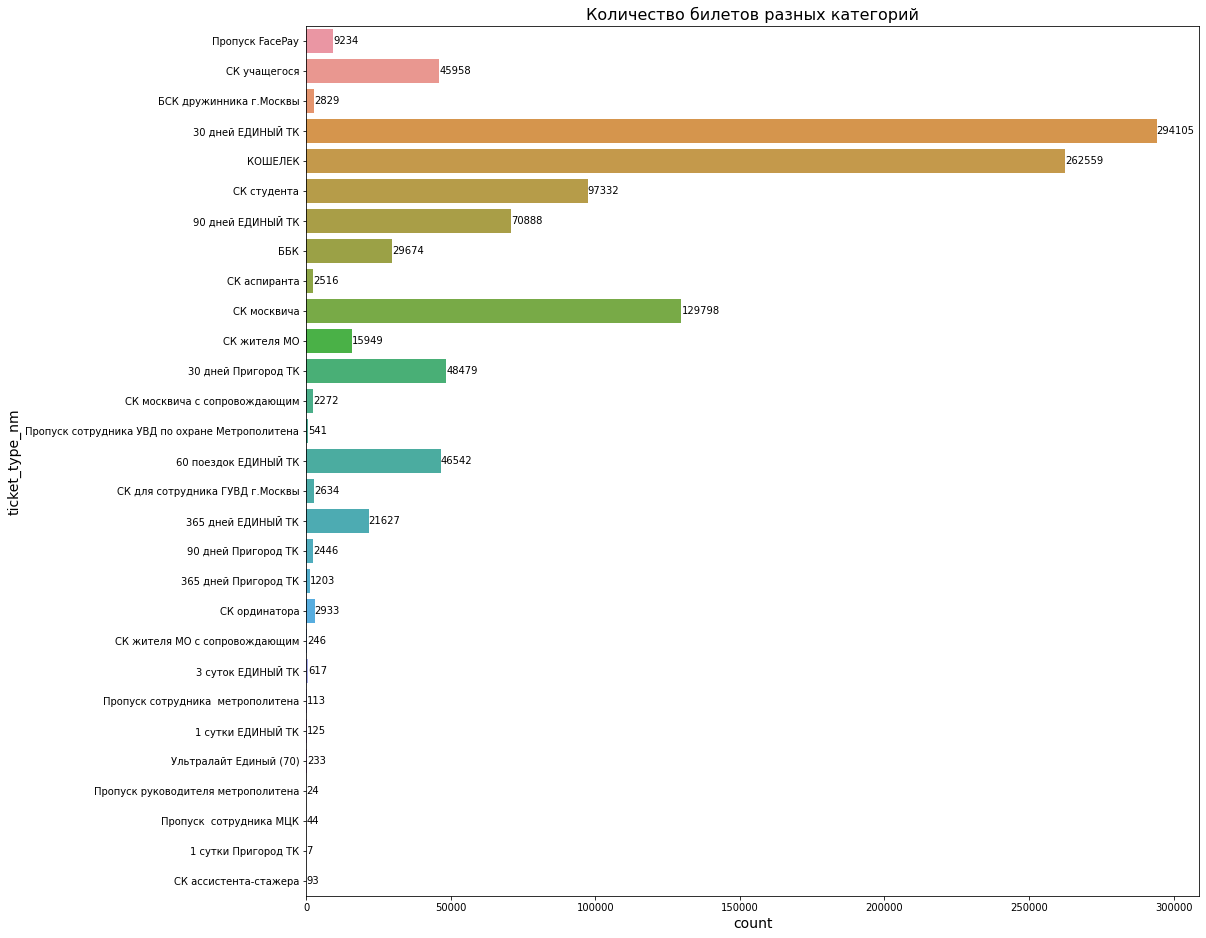

In [20]:
plt.figure(figsize=(16,16))
plt.title('Количество билетов разных категорий', fontsize=16)
plt.xlabel('ticket_type_nm', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax = sns.countplot(y=df_train['ticket_type_nm'])
for container in ax.containers:
    ax.bar_label(container);

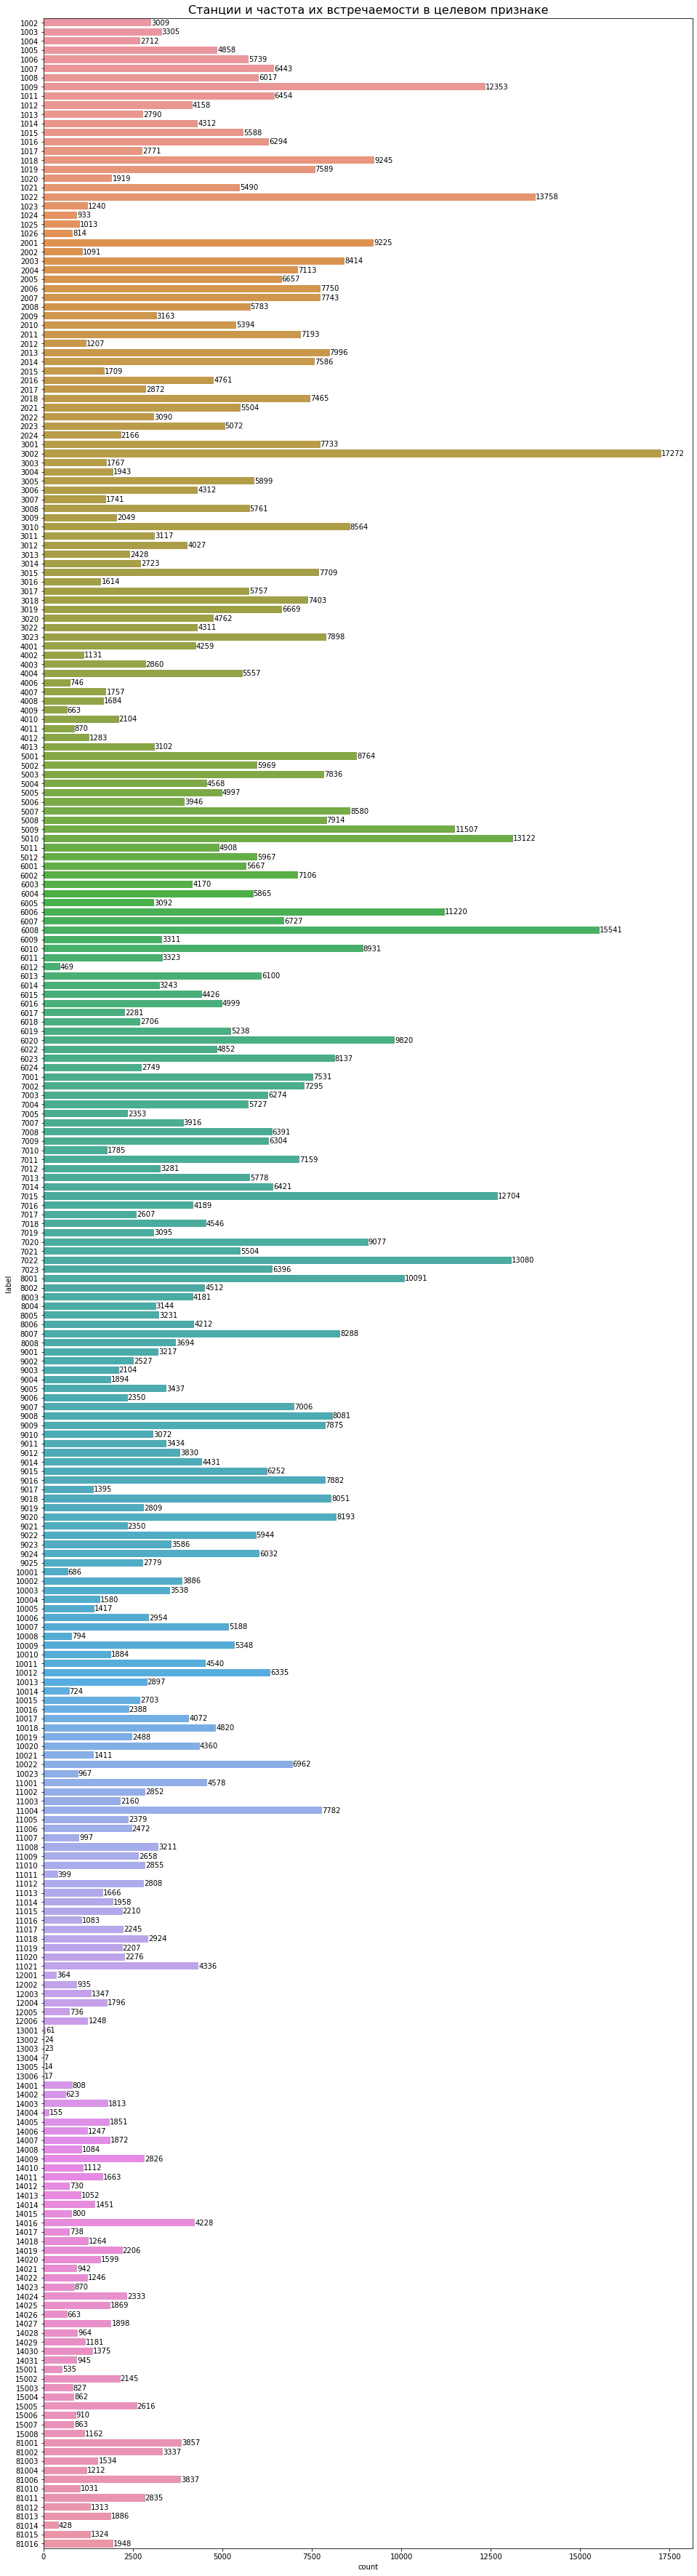

In [21]:
plt.figure(figsize=(16,64))
plt.title('Станции и частота их встречаемости в целевом признаке', fontsize=16)
ax = sns.countplot(y=df_train['label'])
for container in ax.containers:
    ax.bar_label(container);

In [22]:
# pd.set_option('display.max_rows', None)
df_train.groupby('station_nm')['station_id'].value_counts()

station_nm        station_id
Авиамоторная      8001          5281
                  11008          393
Автозаводская     2001          5221
                  14001          738
Академическая     6001          7327
                                ... 
Электрозаводская  11009          292
Юго-Восточная     15008         2428
Юго-Западная      1022          7638
Южная             9025          5059
Ясенево           6024          8482
Name: station_id, Length: 276, dtype: int64

In [23]:
len(df_train.entrance_id.unique())

426

In [24]:
len(df_train.entrance_nm.unique())

426

In [25]:
len(df_train.station_id.unique())

276

In [26]:
len(df_train.station_nm.unique())

245

In [27]:
df_train.entrance_nm.value_counts()

Щёлковская ( Северный )        17810
Кузьминки (Восточный)          13530
Некрасовка (Первый)            12205
Славянский бульвар (Восток)    11963
Новогиреево (Восточный)        11949
                               ...  
ВВЦ                               16
Ул. Эйзенштейна                   10
Ул. Ак. Королёва                   9
Телецентр                          8
Мнёвники (Второй)                  4
Name: entrance_nm, Length: 426, dtype: int64

In [28]:
df_train.entrance_nm.value_counts().sort_index()

Авиамоторная                  5281
Авиамоторная БКЛ1              393
Автозаводская ( Северный )    2295
Автозаводская ( Южный )       2926
Автозаводская МЦК              738
                              ... 
Юго-западная ( Южный )        4599
Южная (Северный)              2771
Южная (Южный)                 2288
Ясенево (Северный)            4514
Ясенево (Южный)               3968
Name: entrance_nm, Length: 426, dtype: int64

In [29]:
df_train.station_nm.value_counts()

Щёлковская                  22133
Кузьминки                   20526
Новогиреево                 18725
Некрасовка                  18136
Новокосино                  16353
                            ...  
Улица Милашенкова              20
Выставочный центр              16
Улица Эйзенштейна              10
Улица Академика Королёва        9
Телецентр                       8
Name: station_nm, Length: 245, dtype: int64

In [30]:
df_train.line_id.value_counts()

7     156031
6     125065
2     124918
9     124079
3     112407
10     95624
1      81818
8      61961
14     43385
11     41317
5      31884
15     31858
81     28768
12     16696
4      15077
13       133
Name: line_id, dtype: int64

In [31]:
df_train.line_nm.value_counts()

Таганско-Краснопресненская       156031
Калужско-Рижская                 125065
Замоскворецкая                   124918
Серпуховско-Тимирязевская        124079
Арбатско-Покровская              112407
Люблинско-Дмитровская             95624
Сокольническая                    81818
Калининская                       61961
Московское центральное кольцо     43385
Большая кольцевая                 41317
Кольцевая                         31884
Некрасовская                      31858
Солнцевская                       28768
Бутовская                         16696
Филёвская                         15077
Монорельс                           133
Name: line_nm, dtype: int64

In [32]:
# преобразование столбца pass_dttm в формат datetime и создание на его основе
df_train['pass_dttm'] = pd.to_datetime(df_train['pass_dttm'], format='%Y-%m-%d %H:%M:%S')
# df_train['weekday'] = df_train['pass_dttm'].dt.weekday
df_train['day'] = df_train['pass_dttm'].dt.day
df_train['hour'] = df_train['pass_dttm'].dt.hour
df_train['minute'] = df_train['pass_dttm'].dt.minute
df_train.head(3)

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,days_use_count,day,hour,minute
id,,,,,,,,,,,,,,,
1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,1,12,5,0
2,126727A96489CC976A8C08E5CEB00542,СК учащегося,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,5,12,5,0
3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,5,12,5,0


При достаточно большом временном интервале выборки можно вводить параметр weekday.

In [33]:
df_train['minutes'] = df_train['hour'] * 60 + df_train['minute']
df_train.head()

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,days_use_count,day,hour,minute,minutes
id,,,,,,,,,,,,,,,,
1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,1,12,5,0,300
2,126727A96489CC976A8C08E5CEB00542,СК учащегося,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,5,12,5,0,300
3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,5,12,5,0,300
4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней ЕДИНЫЙ ТК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022,6,12,5,1,301
5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017,4,12,5,2,302


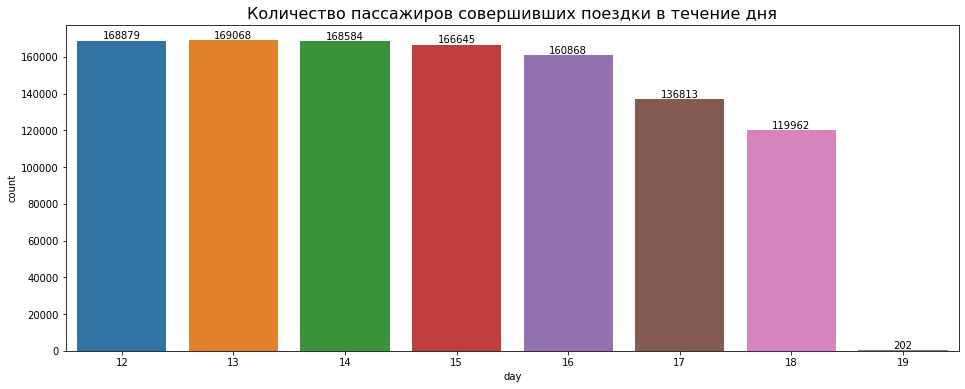

In [34]:
plt.figure(figsize=(16,6))
plt.title('Количество пассажиров совершивших поездки в течение дня', fontsize=16)
ax = sns.countplot(df_train['day'])
for container in ax.containers:
    ax.bar_label(container);

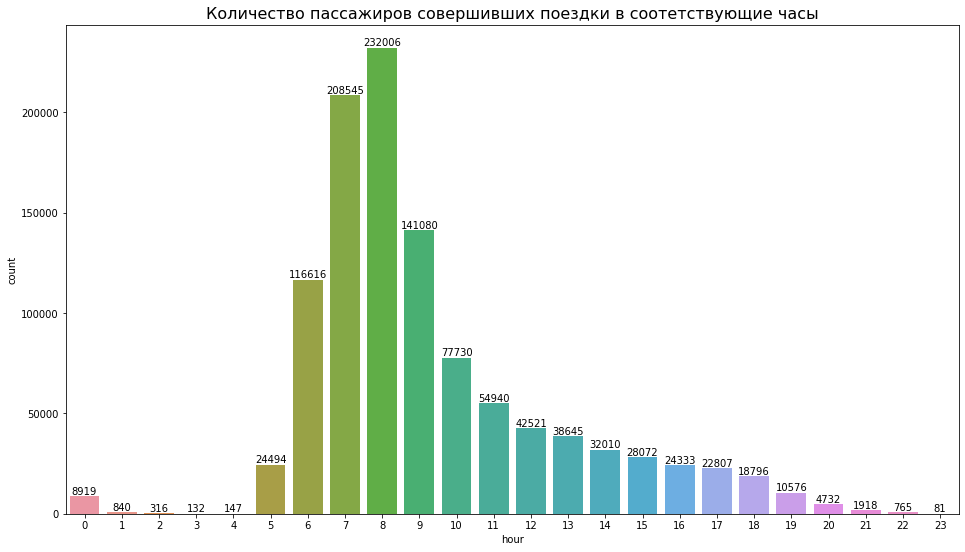

In [35]:
plt.figure(figsize=(16,9))
plt.title('Количество пассажиров совершивших поездки в соотетствующие часы', fontsize=16)
ax = sns.countplot(df_train['hour'])
for container in ax.containers:
    ax.bar_label(container);

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091021 entries, 1 to 1091021
Data columns (total 16 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   ticket_id       1091021 non-null  object        
 1   ticket_type_nm  1091021 non-null  object        
 2   entrance_id     1091021 non-null  int64         
 3   entrance_nm     1091021 non-null  object        
 4   station_id      1091021 non-null  int64         
 5   station_nm      1091021 non-null  object        
 6   line_id         1091021 non-null  int64         
 7   line_nm         1091021 non-null  object        
 8   pass_dttm       1091021 non-null  datetime64[ns]
 9   time_to_under   1091021 non-null  float64       
 10  label           1091021 non-null  int64         
 11  days_use_count  1091021 non-null  int64         
 12  day             1091021 non-null  int64         
 13  hour            1091021 non-null  int64         
 14  minute          10

In [37]:
# преобразование категориального столбца ticket_type_nm в числовой
df_train['ticket_type_nm'] = pd.Categorical(df_train['ticket_type_nm'])
df_train['ticket_type_nm'].astype('category').cat.codes
df_train['ticket_type_nm'] = df_train['ticket_type_nm'].cat.codes
df_train.head(3)

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,days_use_count,day,hour,minute,minutes
id,,,,,,,,,,,,,,,,
1,40BD89EC85646EFB69E283F39C298E60,14,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,1,12,5,0,300
2,126727A96489CC976A8C08E5CEB00542,27,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,5,12,5,0,300
3,D28CE6A9E0E5B6D213470A97CFF32485,11,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,5,12,5,0,300


In [38]:
# удаление дублирующих категориальных и мультиколлинеарных столбцов
df_train = df_train.drop(['ticket_id',
                          'entrance_id',
                          'entrance_nm',
                          'station_nm',
                          'line_nm',
                          'pass_dttm',
                          'hour',
                          'minute'], axis=1)
df_train

,ticket_type_nm,station_id,line_id,time_to_under,label,days_use_count,day,minutes
id,,,,,,,,
1,14,11007,11,216.316667,8001,1,12,300
2,27,2006,2,648.183333,9011,5,12,300
3,11,2006,2,865.333333,7022,5,12,300
4,3,2006,2,1048.233333,2022,6,12,301
5,12,2006,2,965.600000,2017,4,12,302
...,...,...,...,...,...,...,...,...
1091017,14,15005,15,124.750000,15005,1,19,174
1091018,14,6007,6,56.066667,6007,2,19,186
1091019,14,2010,2,91.283333,2010,1,19,197


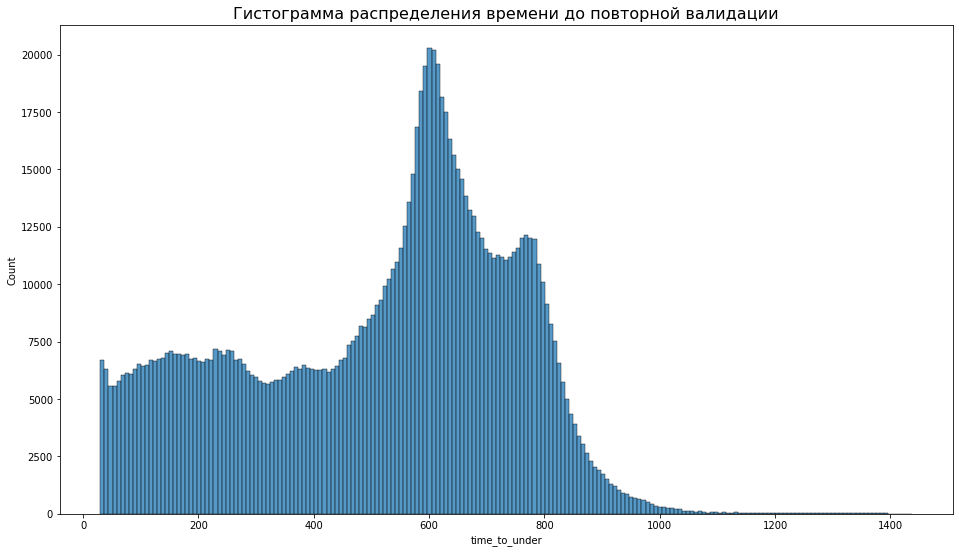

In [39]:
plt.figure(figsize=(16,9))
plt.title('Гистограмма распределения времени до повторной валидации', fontsize=16)
sns.histplot(data=df_train, x='time_to_under');

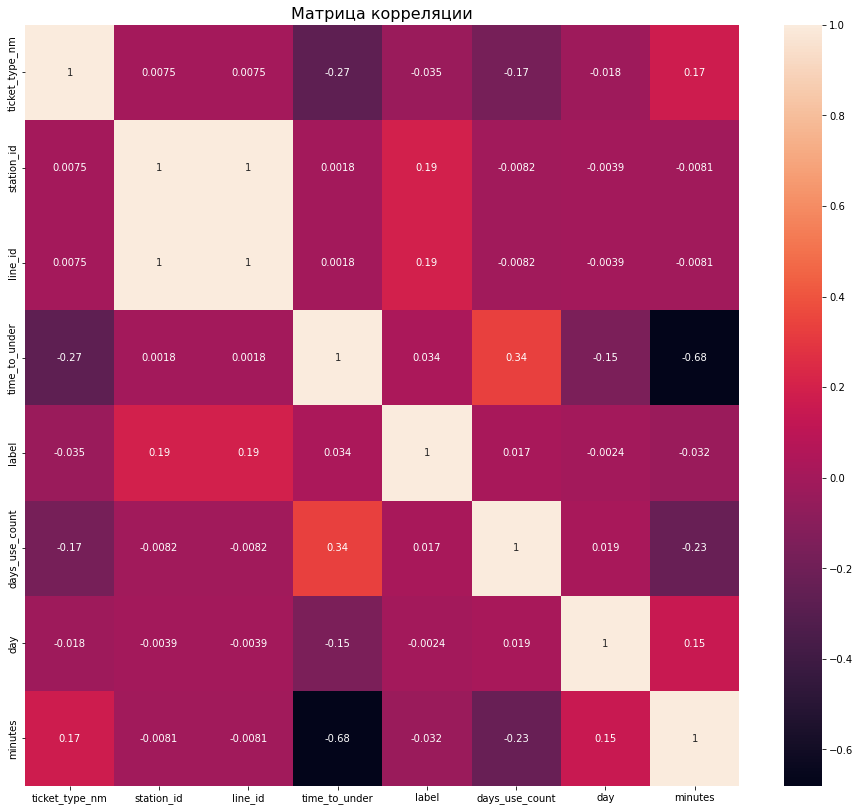

In [40]:
plt.figure(figsize=(16,14))
plt.title('Матрица корреляции', fontsize=16)
sns.heatmap(df_train.corr(), annot = True);

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091021 entries, 1 to 1091021
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   ticket_type_nm  1091021 non-null  int8   
 1   station_id      1091021 non-null  int64  
 2   line_id         1091021 non-null  int64  
 3   time_to_under   1091021 non-null  float64
 4   label           1091021 non-null  int64  
 5   days_use_count  1091021 non-null  int64  
 6   day             1091021 non-null  int64  
 7   minutes         1091021 non-null  int64  
dtypes: float64(1), int64(6), int8(1)
memory usage: 67.6 MB


## Обучение моделей

Разобьем датасет на признаки и дополнительно удалим мультиколлинеарность из features.

In [42]:
features = df_train.drop(['time_to_under', 'label', 'line_id'], axis=1)
target = df_train[['time_to_under', 'label']]

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.1, random_state=12345)

In [43]:
features_train.shape, features_valid.shape, target_train.shape, target_valid.shape

((981918, 5), (109103, 5), (981918, 2), (109103, 2))

In [44]:
# масштабирование численных признаков
scaler = StandardScaler()

features_train = scaler.fit_transform(features_train)
features_valid = scaler.fit_transform(features_valid)

In [45]:
%%time
# время до следующей поездки
lgbm_reg = LGBMRegressor(random_state=12345)
lgbm_reg.fit(features_train, target_train['time_to_under'])
pred_lgbm_reg = lgbm_reg.predict(features_valid)
pred_lgbm_reg

Wall time: 4.56 s


array([687.50261496, 499.9289695 , 614.39748763, ..., 572.12920479,
       714.14471464, 608.8676557 ])

In [46]:
r2_score(target_valid["time_to_under"], pred_lgbm_reg)

0.5585896464322043

In [47]:
%%time
ovr_lgb_class = OneVsRestClassifier(LGBMClassifier(random_state=12345))
ovr_lgb_class.fit(features_train, target_train['label'])
pred_ovr_lgb_class = ovr_lgb_class.predict(features_valid)
pred_ovr_lgb_class

Wall time: 21min 46s


array([10006, 14025,  6010, ...,  9017, 13004, 10004], dtype=int64)

In [48]:
recall_score(target_valid["label"], pred_ovr_lgb_class , average='macro')

0.021018507211261684

In [49]:
score = 0.5 * recall_score(target_valid["label"], pred_ovr_lgb_class , average='macro') +  0.5 * r2_score(target_valid["time_to_under"], pred_lgbm_reg)
score

0.289804076821733

## Получение итогового результата

In [50]:
df_test = df_test.set_index('id')

In [51]:
# столбец с количеством дней, в которые пассажир пользовался билетом
df_test['days_use_count'] = df_test['ticket_id'].map(df_test['ticket_id'].value_counts())
df_test.head()

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,days_use_count
id,,,,,,,,,,
1091022,425A13E16226CA01032043111488E0F5,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03,4
1091023,F94EDC107A4E054786882F9453C1B93F,Пропуск FacePay,184,Молодёжная (Западный),3010,Молодёжная,3,Арбатско-Покровская,2022-09-12 05:00:45,3
1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,СК студента 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:52,6
1091025,7B98691636EC418ABF6FEDDE4D7C68FC,КОШЕЛЕК,107,Сокол ( Южн./Вост. ),2018,Сокол,2,Замоскворецкая,2022-09-12 05:00:58,3
1091026,679C55C28CB36FB546FD104502C0B3DB,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:39,2


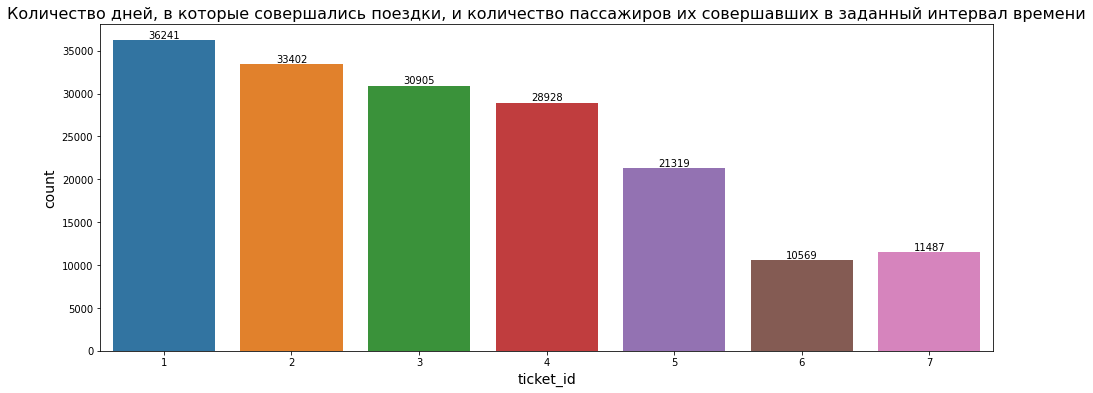

In [52]:
plt.figure(figsize=(16,6))
plt.title('Количество дней, в которые совершались поездки, и количество пассажиров их совершавших в заданный интервал времени', fontsize=16)
plt.xlabel('Количество дней', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax = sns.countplot(df_test.ticket_id.value_counts().sort_values(ascending=False))
for container in ax.containers:
    ax.bar_label(container);

In [53]:
df_test.ticket_type_nm.value_counts().sort_index()

1 сутки ЕДИНЫЙ ТК                                             71
1 сутки Пригород ТК                                           10
3 суток Единый ТК                                            224
30 дней                                                    60807
30 дней  Пригород                                           1666
30 дней ЕДИНЫЙ ТК                                          90977
30 дней Пригород ТК                                        22854
30 дней СК аспиранта                                         424
30 дней СК ассистента-стажера                                 14
30 дней СК ординатора                                        668
30 дней СК студента                                        24952
30 дней СК учащегося                                       12493
365 дней                                                     341
365 дней  Пригород                                            21
365 дней ЕДИНЫЙ ТК                                         11215
365 дней Пригород ТК     

In [54]:
df_test['ticket_type_nm'] = df_test['ticket_type_nm'].replace({'СК студента 30 дней':'СК студента',
                                                                'СК студента 90 дней':'СК студента',
                                                                'СК учащегося 30 дней':'СК учащегося',
                                                                'СК учащегося 90 дней':'СК учащегося',
                                                                'СК ординатора 30 дней':'СК ординатора',
                                                                'СК ординатора 90 дней':'СК ординатора',
                                                                'СК аспиранта 30 дней':'СК аспиранта',
                                                                'СК аспиранта 90 дней':'СК аспиранта',
                                                                'СК ассистента-стажера 30 дней':'СК ассистента-стажера',
                                                                'СК ассистента-стажера 90 дней':'СК ассистента-стажера',
                                                                
                                                                '30 дней СК студента':'СК студента',
                                                                '90 дней СК студента':'СК студента',
                                                                '30 дней СК учащегося':'СК учащегося',
                                                                '90 дней СК учащегося':'СК учащегося',
                                                                '30 дней СК ординатора':'СК ординатора',
                                                                '90 дней СК ординатора':'СК ординатора',
                                                                '30 дней СК аспиранта':'СК аспиранта',
                                                                '90 дней СК аспиранта':'СК аспиранта',
                                                                '30 дней СК ассистента-стажера':'СК ассистента-стажера',
                                                                
                                                                '30 дней  Пригород':'30 дней Пригород ТК',
                                                                '90 дней  Пригород':'90 дней Пригород ТК',
                                                                '365 дней  Пригород':'365 дней Пригород ТК',
                                                                'Билет 3 суток ЕДИНЫЙ':'3 суток ЕДИНЫЙ ТК',
                                                                '3 суток Единый ТК':'3 суток ЕДИНЫЙ ТК',
                                                                'Билет 1 сутки ЕДИНЫЙ':'1 сутки ЕДИНЫЙ ТК',
                                                                 
                                                                '30 дней':'30 дней ЕДИНЫЙ ТК',
                                                                '90 дней':'90 дней ЕДИНЫЙ ТК',
                                                                '365 дней':'365 дней ЕДИНЫЙ ТК',
                                                                
                                                                'Социальная карта жителя Моск. области':'СК жителя МО',
                                                                'Социальная карта жителя Моск. области с сопровождающим':'СК жителя МО с сопровождающим',
                                                                'Социальная карта москвича':'СК москвича',
                                                                'Социальная карта москвича с сопровождающим':'СК москвича с сопровождающим',
                                                                'ВЕСБ МО (7 мин)':'СК жителя МО',
                                                                'ВЕСБ МО (тип 5)':'СК жителя МО',
                                                                'ВЕСБ МО (тип 6)':'СК жителя МО',
                                                                'ВЕСБ МО с сопровождающим':'СК жителя МО с сопровождающим',
                                                                'ВЕСБ МОСКВА':'СК москвича',
                                                                'ВЕСБ МОСКВА (7мин)':'СК москвича',
                                                                'ВЛБ МОСКВА':'СК москвича',
                                                                'Временный билет ММ':'СК москвича',
                                                                'Безналичная транспортная карта':'КОШЕЛЕК',
                                                               
                                                               'СК студента на 3 месяца':'СК студента'})

df_test.ticket_type_nm.value_counts().sort_index()

1 сутки ЕДИНЫЙ ТК                                     71
1 сутки Пригород ТК                                   10
3 суток ЕДИНЫЙ ТК                                    271
30 дней ЕДИНЫЙ ТК                                 151784
30 дней Пригород ТК                                24520
365 дней ЕДИНЫЙ ТК                                 11556
365 дней Пригород ТК                                 720
60 поездок ЕДИНЫЙ ТК                               23828
90 дней ЕДИНЫЙ ТК                                  36457
90 дней Пригород ТК                                 1429
ББК                                                15183
БСК дружинника г.Москвы                             1578
КОШЕЛЕК                                           134808
Пропуск  сотрудника МЦК                               39
Пропуск FacePay                                     4795
Пропуск руководителя метрополитена                     7
Пропуск сотрудника  метрополитена                     64
Пропуск сотрудника УВД по охран

In [55]:
df_test['pass_dttm'] = pd.to_datetime(df_test['pass_dttm'], format='%Y-%m-%d %H:%M:%S')
# df_train['weekday'] = df_train['pass_dttm'].dt.weekday
df_test['day'] = df_test['pass_dttm'].dt.day
df_test['hour'] = df_test['pass_dttm'].dt.hour
df_test['minute'] = df_test['pass_dttm'].dt.minute
df_test.head(3)

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,days_use_count,day,hour,minute
id,,,,,,,,,,,,,
1091022,425A13E16226CA01032043111488E0F5,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03,4,12,5,0
1091023,F94EDC107A4E054786882F9453C1B93F,Пропуск FacePay,184,Молодёжная (Западный),3010,Молодёжная,3,Арбатско-Покровская,2022-09-12 05:00:45,3,12,5,0
1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,СК студента,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:52,6,12,5,0


In [56]:
df_test['minutes'] = df_test['hour'] * 60 + df_test['minute']
df_test.head()

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,days_use_count,day,hour,minute,minutes
id,,,,,,,,,,,,,,
1091022,425A13E16226CA01032043111488E0F5,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03,4,12,5,0,300
1091023,F94EDC107A4E054786882F9453C1B93F,Пропуск FacePay,184,Молодёжная (Западный),3010,Молодёжная,3,Арбатско-Покровская,2022-09-12 05:00:45,3,12,5,0,300
1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,СК студента,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:52,6,12,5,0,300
1091025,7B98691636EC418ABF6FEDDE4D7C68FC,КОШЕЛЕК,107,Сокол ( Южн./Вост. ),2018,Сокол,2,Замоскворецкая,2022-09-12 05:00:58,3,12,5,0,300
1091026,679C55C28CB36FB546FD104502C0B3DB,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:39,2,12,5,1,301


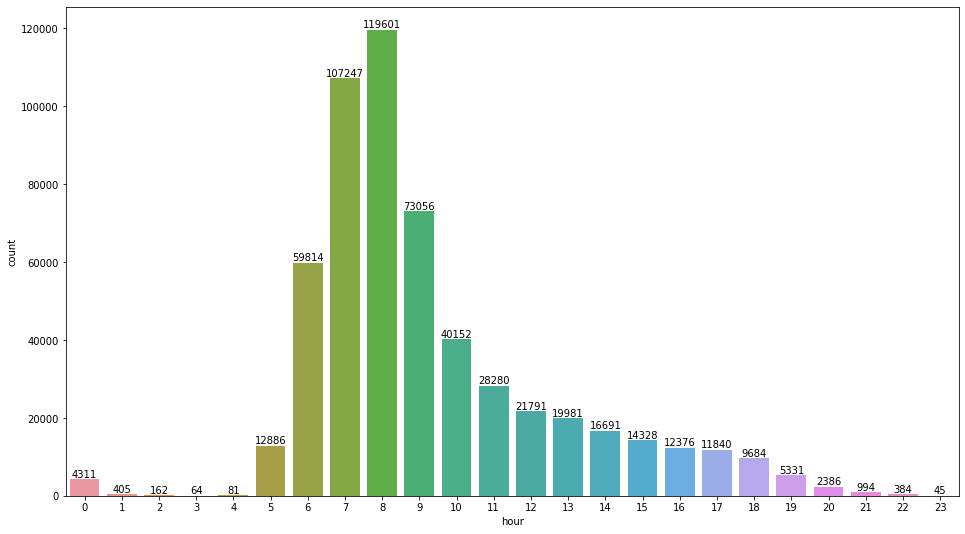

In [57]:
plt.figure(figsize=(16,9))
ax = sns.countplot(df_test['hour'])
for container in ax.containers:
    ax.bar_label(container);

In [58]:
df_test['ticket_type_nm'] = pd.Categorical(df_test['ticket_type_nm'])
df_test['ticket_type_nm'].astype('category').cat.codes
df_test['ticket_type_nm'] = df_test['ticket_type_nm'].cat.codes
df_test.head(3)

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,days_use_count,day,hour,minute,minutes
id,,,,,,,,,,,,,,
1091022,425A13E16226CA01032043111488E0F5,12,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03,4,12,5,0,300
1091023,F94EDC107A4E054786882F9453C1B93F,14,184,Молодёжная (Западный),3010,Молодёжная,3,Арбатско-Покровская,2022-09-12 05:00:45,3,12,5,0,300
1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,26,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:52,6,12,5,0,300


In [59]:
df_test = df_test.drop(['ticket_id',
                        'entrance_id',
                        'entrance_nm',
                        'station_nm',
                        'line_nm',
                        'pass_dttm',
                        'hour',
                        'minute',
                        'line_id'], axis=1)

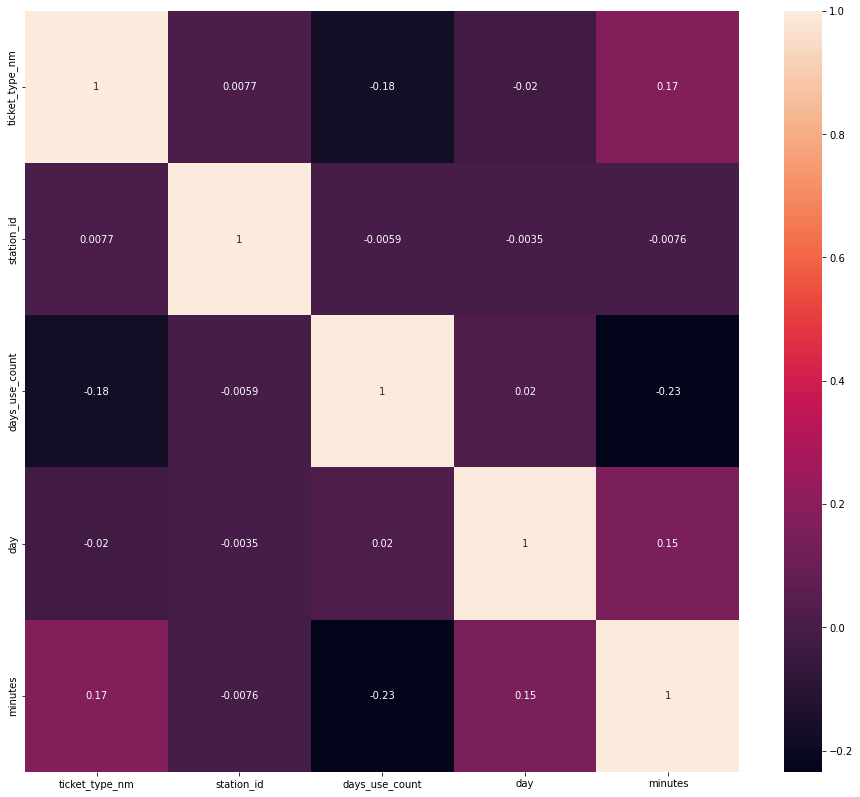

In [60]:
plt.figure(figsize=(16,14))
sns.heatmap(df_test.corr(), annot = True);

In [61]:
# масштабирование численных признаков
scaler = StandardScaler()

df_test_scaled = scaler.fit_transform(df_test)

In [62]:
%%time
# время до следующей поездки
pred_lgbm_reg_test = lgbm_reg.predict(df_test_scaled)
pred_lgbm_reg_test

Wall time: 1.58 s


array([772.28895164, 475.52281648, 784.28413706, ..., 159.16522076,
       175.55216703, 140.64974864])

In [65]:
%%time
# станция следующей поездки
pred_lgbm_class_test = ovr_lgb_class.predict(df_test_scaled)
pred_lgbm_class_test

Wall time: 5min 52s


array([13006,  3017, 13006, ...,  1025, 10021,  3013], dtype=int64)

In [66]:
solution = df_test.drop(['ticket_type_nm', 'station_id', 'days_use_count', 'day', 'minutes'], axis=1)
solution['time_to_under'] = pred_lgbm_reg_test
solution['label'] = pred_lgbm_class_test
solution = solution.reset_index()
solution

,id,time_to_under,label
0,1091022,772.288952,13006
1,1091023,475.522816,3017
2,1091024,784.284137,13006
3,1091025,676.517236,13006
4,1091026,679.756390,13006
...,...,...,...
561885,1652907,161.279473,10021
561886,1652908,142.667958,14027
561887,1652909,159.165221,1025
561888,1652910,175.552167,10021


In [67]:
solution.to_csv('C:/data/hackathon/amur_champ/subway/solution.csv', index=False)